# Let's go

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [2]:
from cpymad.madx import Madx

import sixtracklib as pyst
from sixtracklib import stcommon as st

In [3]:
from scipy.constants import e, c, epsilon_0

In [4]:
import sys
sys.path = ["/home/oeftiger/gsi/git/python3/PyHEADTAIL/", 
            "/home/oeftiger/gsi/git/"] + sys.path

try:
    from PyHEADTAIL.trackers.rf_bucket import RFBucket
except:
    pass

PyHEADTAIL v1.13.5




/home/oeftiger/anaconda3/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [5]:
nmass = 0.931494061 # MAD-X value

In [6]:
n_macroparticles = int(1e4)
n_turns = 1024

Qs = 1e-3
bunch_length = 10e-9 # in [s]

Ekin_per_nucleon = 100e6 # in eV

circumference = 10

A = 1#238
Q = 1#28

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV
Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

sigma_z = beta * c * bunch_length / 4. # in [m]

eta = -gamma**-2
# Qs = np.sqrt(e * rf_voltage * 1 * -eta / (2 * np.pi * p0 * beta * c))
rf_voltage = 2 * np.pi * p0 * beta * c * Qs**2 / (charge * 1 * -eta)
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)

# beta_z = sigma_z / sigma_dp
sigma_dp = sigma_z / beta_z
epsn_z = sigma_z * sigma_dp * 4 * np.pi * p0 / e # sigma_z**2 * 4 * np.pi * p0 / (e * beta_z)

In [7]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.08.22 18:35:55      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [8]:
madx.input('''
kqd := -0.1;
kqf := 0.1;
v := 0;

qd: multipole, knl := {0, kqd/2.};
qf: multipole, knl := {0, kqf};
rf: rfcavity, volt := v, harmon = 1, lag = 0; //, lag = 0.5;

fodo: sequence, l = ''' + str(circumference) + ''';
qd, at = 0;
qf, at = 5;
rf, at = 5;
qd, at = 10;
endsequence;
''')

True

In [9]:
madx.command.beam(particle='ion', mass=A * nmass, charge=Q, energy=Etot) # energy in GeV

True

In [10]:
madx.use(sequence='fodo')

In [11]:
madx.input('v := {}'.format(rf_voltage * 1e-6)) # MV

++++++ info: v redefined


True

In [12]:
madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0    8.048713384e-06        352.4818578 

                q1                dq1            betxmax              dxmax 
     0.08043062326        -0.19134103        25.81988897                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0      0.08043062326 

               dq2            betymax              dymax              dyrms 
       -0.19134103        25.81988897                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

# on the GPU

In [13]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c)

In [14]:
elements = pyst.Elements.from_mad(madx.sequence.FODO, exact_drift=True)

In [15]:
elements.BeamMonitor(num_stores=n_turns);

In [16]:
trackjob = pyst.CudaTrackJob(elements, pyst_beam)

In [17]:
pyst_beam.zeta[:] = np.random.uniform(-3, 3, size=n_macroparticles)

In [18]:
elements.get_elements()[-1]

<BeamMonitor at 400
  num_stores:1024
  start:0
  skip:1
  out_address:139986631782544
  max_particle_id:9999
  min_particle_id:0
  is_rolling:0
  is_turn_ordered:1
>

In [19]:
trackjob.track_until(n_turns)

In [20]:
trackjob.collect()

In [21]:
z = trackjob.output.particles[0].zeta
dp = trackjob.output.particles[0].delta

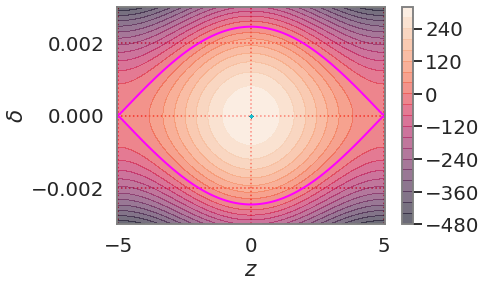

In [22]:
try:
    rfb = RFBucket(circumference, gamma, mass, charge, [0], 0, [1], [rf_voltage], [np.pi])

    plz = np.linspace(*rfb.interval, num=100)
    pldp = np.linspace(-0.003, 0.003, num=100)
    ZZ, DPP = np.meshgrid(plz, pldp)
    HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
    plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
    plt.colorbar()
    plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
except:
    pass

for i in range(100):
    plt.scatter(z[i::n_macroparticles], dp[i::n_macroparticles], s=10, marker='.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

In [23]:
trackjob.collectBeamElements()

In [24]:
elements.get_elements()[-1]

<BeamMonitor at 400
  num_stores:1024
  start:0
  skip:1
  out_address:139984828891264
  max_particle_id:0
  min_particle_id:0
  is_rolling:0
  is_turn_ordered:1
>

$\implies$ max_particle_id is 0

# on the CPU

In [25]:
del pyst_beam, elements, trackjob

In [26]:
pyst_beam = pyst.Particles.from_ref(num_particles=n_macroparticles, p0c=p0c, q0=Q, mass0=mass * c**2/e)

In [27]:
elements = pyst.Elements.from_mad(madx.sequence.FODO, exact_drift=True)

In [28]:
elements.BeamMonitor(num_stores=n_turns);

In [29]:
trackjob = pyst.TrackJob(elements, pyst_beam)

In [30]:
pyst_beam.zeta[:] = np.random.uniform(-3, 3, size=n_macroparticles)

In [31]:
elements.get_elements()[-1]

<BeamMonitor at 400
  num_stores:1024
  start:0
  skip:1
  out_address:139982907240592
  max_particle_id:9999
  min_particle_id:0
  is_rolling:0
  is_turn_ordered:1
>

In [32]:
trackjob.track(n_turns)

0

In [33]:
trackjob.collect()

In [34]:
z = trackjob.output.particles[0].zeta
dp = trackjob.output.particles[0].delta

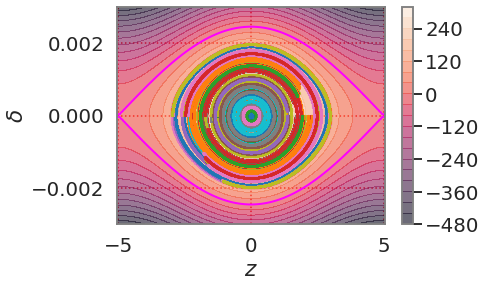

In [35]:
try:
    rfb = RFBucket(circumference, gamma, mass, charge, [0], 0, [1], [rf_voltage], [np.pi])

    plz = np.linspace(*rfb.interval, num=100)
    pldp = np.linspace(-0.003, 0.003, num=100)
    ZZ, DPP = np.meshgrid(plz, pldp)
    HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
    plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
    plt.colorbar()
    plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta', linewidths=2)
except:
    pass

for i in range(100):
    plt.scatter(z[i::n_macroparticles], dp[i::n_macroparticles], s=10, marker='.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

In [36]:
rfb.Q_s

0.001

In [37]:
pyst_beam.gamma0

array([1.10735442, 1.10735442, 1.10735442, ..., 1.10735442, 1.10735442,
       1.10735442])

In [38]:
gamma

1.1073544150057657

In [39]:
pyst_beam.q0

array([1., 1., 1., ..., 1., 1., 1.])

In [40]:
pyst_beam.mass0

array([9.31494061e+08, 9.31494061e+08, 9.31494061e+08, ...,
       9.31494061e+08, 9.31494061e+08, 9.31494061e+08])

In [41]:
"%e"%(mass * c**2/e)

'9.314941e+08'

In [42]:
pyst_beam.chi

array([1., 1., 1., ..., 1., 1., 1.])

In [43]:
pyst_beam.charge_ratio

array([1., 1., 1., ..., 1., 1., 1.])

# Version of SixTrackLib:

In [44]:
!cd /home/oeftiger/gsi/git/sixtracklib_aoeftiger/ && git log | head -16

commit 19fb4bd7fba65e308b5f657ed2db13d38e8d3169
Author: Adrian Oeftiger <a.oeftiger@gsi.de>
Date:   Fri Aug 16 14:00:39 2019 +0200

    python beam_elements: fixing bug in temporary Element.from_mad

commit cabf84888326e4370df79582a2ab9fc5953aa1c2
Merge: 6ba286e a6ee576
Author: Martin Schwinzerl <martin.schwinzerl@cern.ch>
Date:   Sun Jul 28 15:49:01 2019 +0200

    Merge pull request #90 from giadarol/master
    
    thank you for the merge request.
    Verified that all unit-tests pass. I've opened an issues concerning the missing C++ bindings and the upcoming changes to handling kernels with disabled beam-fields support as #91 and #92 respectively.

